# Working with ATL08 Canopy data 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.crs as crs
import cartopy.feature as cfeature
import h5py  
from astropy.time import Time
import os

In [2]:
# reads H5 file and reads through file to store data - might need to change data to be on github not my own computer?
f = h5py.File('C:\\Users\\samgr\\OneDrive\\Desktop\\masters_year\\Masters_Project\\Preparation\\ICESat2_Data\\177219966\\ATL08_20181014141223_02440101_003_01.h5', 'r')
mean_canopy = f['/gt1r/land_segments/canopy/h_mean_canopy'][:]
min_canopy = f['/gt1r/land_segments/canopy/h_min_canopy'][:]
max_canopy = f['/gt1r/land_segments/canopy/h_max_canopy'][:]
toc_roughness = f['/gt1r/land_segments/canopy/toc_roughness'][:]
canopy_openness = f['/gt1r/land_segments/canopy/canopy_openness'][:]

latitude = f['/gt1r/land_segments/latitude'] [:]
longitude = f['/gt1r/land_segments/longitude'][:]
dt = f['/gt1r/land_segments/delta_time'][:]
segment_id_beg = f['/gt1r/land_segments/segment_id_beg'][:]
segment_id_end = f['/gt1r/land_segments/segment_id_end'][:]
canopy_rh_conf =f['/gt1r/land_segments/canopy/canopy_rh_conf'][:]
ph_segment_id =f['/gt1r/signal_photons/ph_segment_id'][:]


OSError: Unable to open file (unable to open file: name = 'C:\Users\samgr\OneDrive\Desktop\masters_year\Masters_Project\Preparation\ICESat2_Data\177219966\ATL08_20181014141223_02440101_003_01.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# create pandas dataframe with the columns thought to be useful
# At the end of dataframe, the values of 3.402823e+38 - these are times when the photon did not give a good signal I think?
df08=pd.DataFrame({'latitude':latitude,'longitude':longitude,'delta time':dt,'Segment_id_beg':segment_id_beg,
                   'segment_id_end':segment_id_end,'mean_canopy': mean_canopy,'canopy_rh_conf':canopy_rh_conf, 
                   'canopy_openness':canopy_openness, 'min_canopy':min_canopy, 'max_canopy': max_canopy, 
                   'toc_roughness':toc_roughness})

# Columns that could be useful that requires calculations from other columns
df08["mean_segment_id"] = df08["segment_id_end"] - df08["Segment_id_beg"]
df08["CV"] = df08["canopy_openness"] / df08["mean_canopy"]
df08["sd_ratio"] = df08["toc_roughness"] / df08["canopy_openness"]
df08["canopy_relief"] = (df08["mean_canopy"] - df08["min_canopy"]) / (df08["max_canopy"] - df08["min_canopy"])

df08

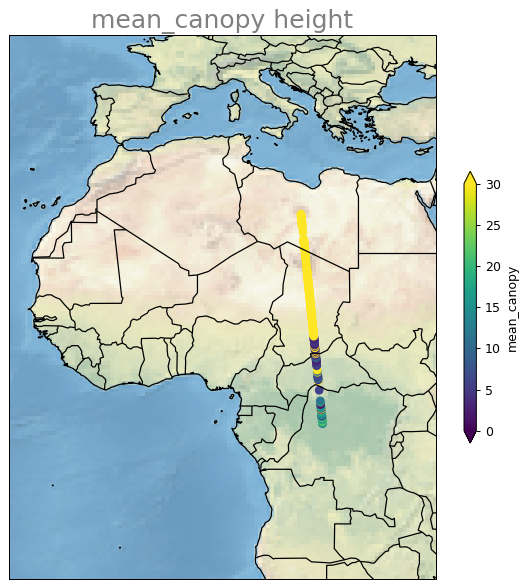

In [4]:
# plotting the data without the correcting for anomalies

variable = 'mean_canopy' #what we want the colour to represent

## variable min and max (I could probably make this automatic) 
vmin=0
vmax=30
ticks=np.arange(-20,100,5)

#size of image
plt.figure(figsize=(8,8), dpi= 90)

#coordinates / projection
ax = plt.axes(projection=crs.PlateCarree())
lat1, lon1, lat2, lon2 = -20, 35, -20, 50
ax.set_extent([lat1, lon1, lat2, lon2], crs=crs.PlateCarree())

#background and design
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.stock_img()
ax.add_feature(cfeature.BORDERS)
ax.set_title('{} height'.format(variable), fontsize = 20, color = 'gray')

#adding variable onto map (and colour bar)
plt.scatter(df08['longitude'][::100], df08['latitude'][::100],c=df08[variable][::100], cmap='viridis', vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
plt.colorbar(label=variable, shrink=0.5, ticks=ticks,extend='both')

*** ALL DATA THAT IS BLOCKED BY CLOUD OR IS EMPTY IS FILLED BY 3.402 X 10^28. THIS ACCOUNTS FOR N SAHARA YELLOW. MUST EXCLUDE FROM SURVEY. ***

In [5]:
# Filter out all rows for which the mean canopy height is higher than 1000m
df08.drop(df08[df08['mean_canopy'] > 1000].index, inplace = True) 

mean_canopy_min = df08["mean_canopy"].min()
mean_canopy_max = df08["mean_canopy"].max()
print("Min mean canopy height is:", mean_canopy_min)
print("Max mean canopy height is:", mean_canopy_max)

Min mean canopy height is: 0.9542641
Max mean canopy height is: 43.112953


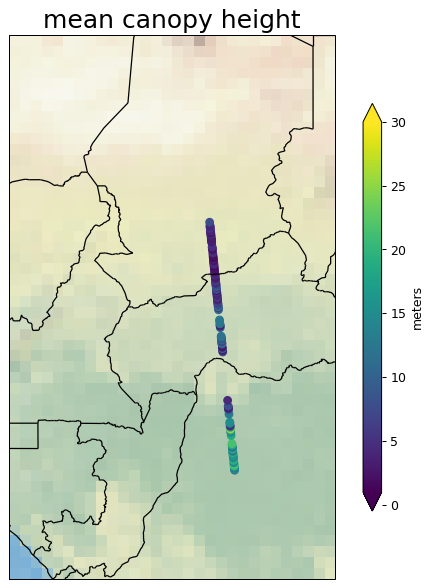

In [13]:
# Plot again, accounting for anomalies

variable = 'mean_canopy' # what we want the colour to represent -  means that we only have to change the variable in one place
                         # but when the data is being used properly will rename it so labels look smarter 

## variable min and max (I've made this automatic - but may look better to round it up/ down) 
vmin= mean_canopy_min
vmax= 30
ticks=np.arange(-20,100,5)

#size of image
plt.figure(figsize=(8,8), dpi= 90)

#coordinates / projection
ax = plt.axes(projection=crs.PlateCarree())
lat1, lon1, lat2, lon2 = 10, 25, -5, 20
ax.set_extent([lat1, lon1, lat2, lon2], crs=crs.PlateCarree())

#background and design
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.stock_img()
ax.add_feature(cfeature.BORDERS)
#ax.set_title('{} height'.format(variable), fontsize = 20, color = 'black')
ax.set_title('mean canopy height', fontsize = 20, color = 'black')

#adding variable onto map (and colour bar)
plt.scatter(df08['longitude'][::50], df08['latitude'][::50],c=df08[variable][::50], cmap='viridis', vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
#plt.colorbar(label=variable, shrink=0.75, ticks=ticks,extend='both')
plt.colorbar(label= "meters", shrink=0.75, ticks=ticks,extend='both')

plt.savefig("C:\\Users\\samgr\\OneDrive\\Desktop\\mean_canopy.png")

Mean canopy height is just an example and we can change this to another variable

Would be it good to create a forloop and try and plot multiple files on one graph, so we get an area not just a line?

*** Next, we want to overlay burned area data/ Vegetation Indices ***

I am still struggling with this, as seen in my other notebook! 

In [7]:
df08["mean_canopy_cut"] = df08["mean_canopy"][::100]

mean_canopy_cut_min = df08["mean_canopy_cut"].min()
mean_canopy_cut_max = df08["mean_canopy_cut"].max()

ValueError: 'c' argument has 5893 elements, which is inconsistent with 'x' and 'y' with size 59.

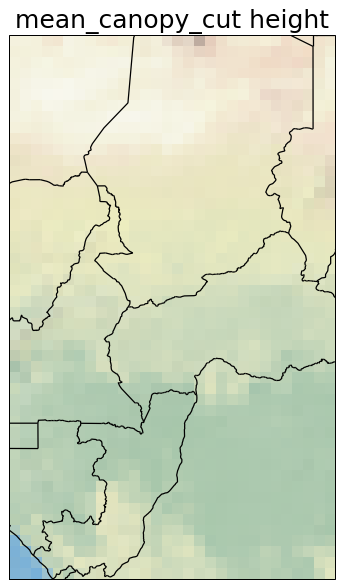

In [8]:
# Plot again, accounting for anomalies

variable = 'mean_canopy_cut' # what we want the colour to represent -  means that we only have to change the variable in one place
                             # but when the data is being used properly will rename it so labels look smarter 

## variable min and max (I've made this automatic - but may look better to round it up/ down) 
vmin= mean_canopy_cut_min
vmax= mean_canopy_cut_max
ticks=np.arange(-20,100,5)

#size of image
plt.figure(figsize=(8,8), dpi= 90)

#coordinates / projection
ax = plt.axes(projection=crs.PlateCarree())
lat1, lon1, lat2, lon2 = 10, 25, -5, 20
ax.set_extent([lat1, lon1, lat2, lon2], crs=crs.PlateCarree())

#background and design
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.stock_img()
ax.add_feature(cfeature.BORDERS)
ax.set_title('{} height'.format(variable), fontsize = 20, color = 'black')

#adding variable onto map (and colour bar)
plt.scatter(df08['longitude'][::100], df08['latitude'][::100],c=df08[variable], cmap='viridis', vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
plt.colorbar(label=variable, shrink=0.75, ticks=ticks,extend='both')
plt.savefig("C:\\Users\\samgr\\OneDrive\\Desktop\\mean_canopy.png")